In [32]:
from __future__ import print_function, division
%matplotlib notebook
import brainweb
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
logging.basicConfig(level=logging.INFO)
import nibabel as nib
import sirf.STIR as pet
import matplotlib.pyplot as plt
import os

os.chdir("/Users/rich/Documents/Data/brainweb/")
# download
# files = brainweb.get_files(".")

# read first file
data = brainweb.load_file(files[0])

In [6]:
brainweb.seed(1337)

for f in tqdm([files[0]], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(
        f,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)

/Users/rich/Documents/Data/brainweb/subject_04.bin.gz


<IPython.core.display.Javascript object>


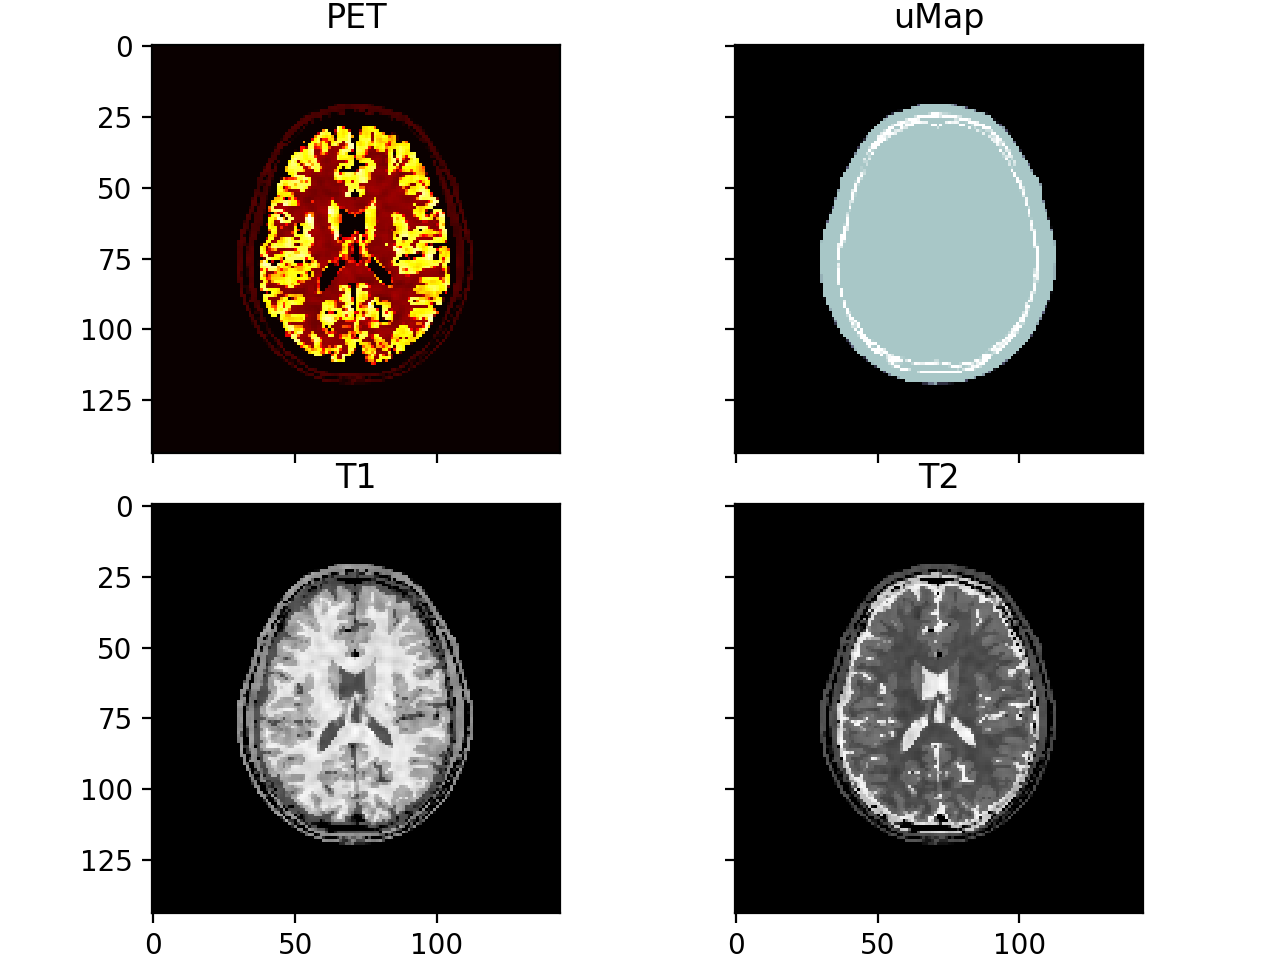

interactive(children=(IntSlider(value=63, description='z', max=126), Output()), _dom_classes=('widget-interact…

In [7]:
print(f)
volshow([vol['PET' ][:, 100:-100, 100:-100],
         vol['uMap'][:, 100:-100, 100:-100],
         vol['T1'  ][:, 100:-100, 100:-100],
         vol['T2'  ][:, 100:-100, 100:-100]],
        cmaps=['hot', 'bone', 'Greys_r', 'Greys_r'],
        titles=["PET", "uMap", "T1", "T2"]);

<IPython.core.display.Javascript object>


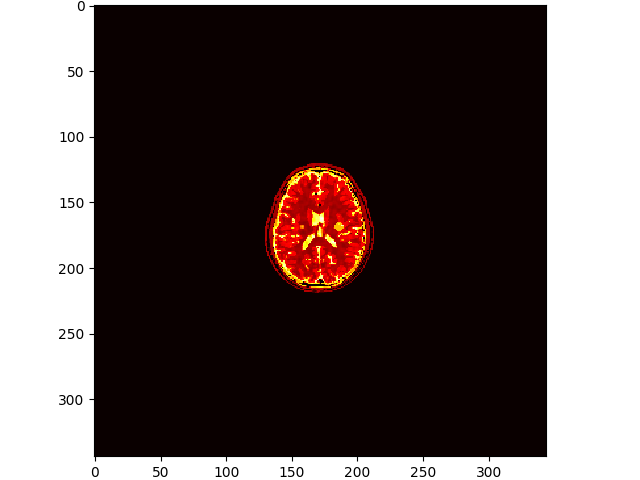

interactive(children=(IntSlider(value=63, description='z', max=126), Output()), _dom_classes=('widget-interact…

In [28]:
# add some lesions
brainweb.seed(1337)
PET_tumour = brainweb.add_lesions(vol['PET']) 
T1_tumour = brainweb.add_lesions(vol['T1'])
T2_tumour = brainweb.add_lesions(vol['T2'])

volshow([vol['PET' ][:, 100:-100, 100:-100],
         vol['uMap'][:, 100:-100, 100:-100],
         T1_tumour  [:, 100:-100, 100:-100],
         T2_tumour  [:, 100:-100, 100:-100]],
        cmaps=['hot', 'bone', 'Greys_r', 'Greys_r'],
        titles=["PET", "uMap", "T1", "T2"]);

## Crop images

In [61]:
def crop_images(in_image):
    out_image = in_image[:,17:17+285,17:17+285]
    return out_image

vol_PET = crop_image(vol['PET'])
vol_uMap = crop_image(vol['uMap'])
vol_T1 = crop_image(vol['T1'])
vol_T2 = crop_image(vol['T2'])
vol_PET_tumour = crop_image(PET_tumour)
vol_T1_tumour = crop_image(T1_tumour)
vol_T2_tumour = crop_image(T2_tumour)

In [62]:
# Originals
nib.save(nib.Nifti1Image(vol['PET'], affine=np.eye(4)),"subj_04_PET")
nib.save(nib.Nifti1Image(vol['uMap'], affine=np.eye(4)),"subj_04_uMap")
nib.save(nib.Nifti1Image(vol['T1'], affine=np.eye(4)),"subj_04_T1")
nib.save(nib.Nifti1Image(vol['T2'], affine=np.eye(4)),"subj_04_T2")

# Tumours
nib.save(nib.Nifti1Image(PET_tumour, affine=np.eye(4)),"subj_04_PET_tumour")
nib.save(nib.Nifti1Image(T1_tumour, affine=np.eye(4)),"subj_04_T1_tumour")
nib.save(nib.Nifti1Image(T2_tumour, affine=np.eye(4)),"subj_04_T2_tumour")

# Original and tumours, cropped
nib.save(nib.Nifti1Image(vol_PET, affine=np.eye(4)),"subj_04_PET_cropped")
nib.save(nib.Nifti1Image(vol_uMap, affine=np.eye(4)),"subj_04_uMap_cropped")
nib.save(nib.Nifti1Image(vol_T1, affine=np.eye(4)),"subj_04_T1_cropped")
nib.save(nib.Nifti1Image(vol_T2, affine=np.eye(4)),"subj_04_T2_cropped")
nib.save(nib.Nifti1Image(vol_PET_tumour, affine=np.eye(4)),"subj_04_PET_tumour_cropped")
nib.save(nib.Nifti1Image(vol_T1_tumour, affine=np.eye(4)),"subj_04_T1_tumour_cropped")
nib.save(nib.Nifti1Image(vol_T2_tumour, affine=np.eye(4)),"subj_04_T2_tumour_cropped")


## Forward project

In [71]:
# We'll need a template sinogram
templ_sino = pet.AcquisitionData('mMR_template_span11_small.hs')

# Attenuation from template
gt_atten = pet.ImageData(templ_sino)
gt_atten.fill(vol_uMap)

#%% create acquisition model
am = pet.AcquisitionModelUsingRayTracingMatrix()
am.set_num_tangential_LORs(5)

# Set up sensitivity due to attenuation
asm_attn = pet.AcquisitionSensitivityModel(gt_atten, am)
asm_attn.set_up(templ_sino)
bin_eff = pet.AcquisitionData(templ_sino)
bin_eff.fill(1.0)
print('applying attenuation (please wait, may take a while)...')
asm_attn.unnormalise(bin_eff)
asm_attn = pet.AcquisitionSensitivityModel(bin_eff)

am.set_acquisition_sensitivity(asm_attn)

am.set_up(templ_sino,gt_atten);

applying attenuation (please wait, may take a while)...


In [80]:
def fwd_prj(am,vol,template_im,add_noise):
    image = template_im.clone()
    image.fill(vol)
    proj_data = am.forward(image)
    if add_noise:
        proj_data_arr = np.abs(proj_data.as_array());
        noisy_array = np.random.poisson(proj_data_arr).astype('float32');
        proj_data.fill(noisy_array);
    return proj_data

## Do PET data w and w/o tumour and w and w/o noise

In [73]:
sino_PET = fwd_prj(am,vol_PET,gt_atten,False)
sino_PET.write("subj_04_sino")

In [74]:
sino_PET_tumour = fwd_prj(am,vol_PET_tumour,gt_atten,False)
sino_PET_tumour.write("subj_04_sino_tumour")

In [81]:
sino_PET_noisy = fwd_prj(am,vol_PET,gt_atten,True)
sino_PET_noisy.write("subj_04_sino_noisy")

In [82]:
sino_PET_noisy_tumour = fwd_prj(am,vol_PET_tumour,gt_atten,True)
sino_PET_noisy_tumour.write("/Users/rich/Documents/Data/brainweb/subj_04_sino_noisy_tumour")